#### Personalized Student Recommendation System for Improved Performance


In [517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from surprise.prediction_algorithms import SVD
from surprise.reader import Reader
from surprise.model_selection import validation, cross_validate
from surprise import Dataset, Reader, SVD
from surprise.accuracy import rmse, mse
import nltk
import re
import string
import random
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from ast import literal_eval
from keras.layers import Input, Embedding, Reshape, Dense, Dot, Concatenate
from keras.models import Model
from keras.utils import plot_model
import pydot

In [518]:
student_behaviour_dataset = pd.read_csv("behavior-performance.txt", sep="\t")
student_behaviour_dataset.head(10)
# student_behaviour_dataset.tail(10)

,userID,VidID,fracSpent,fracComp,fracPlayed,fracPaused,numPauses,avgPBR,stdPBR,numRWs,numFFs,s
0,718eaa5dec19bcf6c7fea0870dd102dbe844fbbb,0,1.145098,0.995568,0.995568,0.000000,0,1.500000,0.000000e+00,0,0,0
1,210f854b0afc3d476d711b2b41379954e48cfa44,0,0.573497,0.858001,0.858001,1.998006,6,1.500000,2.220446e-16,0,4,0
2,e16cf25ff5bb827bf3b5a0c8afeed15c2223a8b5,0,0.778732,0.829160,1.137497,0.051103,1,1.462199,8.956206e-02,2,0,1
3,46dff32368088c11707106514f0450518d19b30d,0,0.639626,0.857684,0.860312,0.000000,0,1.345555,2.111871e-01,1,7,0
4,8a861f5af4ed0668eb03bd8a77d2b7ced04f901e,0,0.786526,0.754330,1.051675,0.000000,0,1.339290,2.451593e-01,6,0,1
5,a5cd61ab53a41471ed8e02f49382adbe32abab21,0,0.805740,0.995563,0.995563,0.000000,0,1.236395,5.671128e-02,0,0,1
6,df52ec6e38a415b7ca73c2abdc98d28080944063,0,0.995671,0.994676,0.994676,1.441899,3,1.000000,0.000000e+00,0,0,0
7,23f1a996532c1f6364409247f5cf5f39a74ed51c,0,0.936930,0.361980,1.042555,0.000000,0,1.115971,1.195400e-01,0,22,1
8,721c5aba958a008c0c12576d213d3e31f938acd3,0,69.597869,0.995504,0.995504,0.000000,0,1.250000,4.440892e-16,0,0,0
9,4b6c249e8bad484758f705bba03448d62f8c55a1,0,0.997142,0.995478,0.995478,0.000000,0,1.000000,0.000000e+00,0,0,1


In [519]:
## clean names
colnames = list(student_behaviour_dataset.columns)
student_behaviour_dataset.columns = [colname.lower() for colname in colnames]
student_behaviour_dataset.describe()

,vidid,fracspent,fraccomp,fracplayed,fracpaused,numpauses,avgpbr,stdpbr,numrws,numffs,s
count,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000
mean,19.830433,24.076515,0.767870,0.985555,36.340134,2.825519,1.104374,0.014451,2.238022,1.567602,0.663322
std,22.506358,308.275794,0.340593,3.723574,375.758642,59.101914,0.315582,0.050013,15.564590,6.370014,0.472582
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.711898,0.601168,0.990654,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.996586,0.991777,0.995724,0.104929,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,28.000000,1.050659,0.995560,1.035128,0.661808,3.000000,1.250000,0.000000,2.000000,1.000000,1.000000
max,92.000000,18215.984634,9.288731,439.649941,15957.392024,10083.000000,2.000000,0.979936,2237.000000,309.000000,1.000000


In [520]:
# zeros = (student_behaviour_dataset == 0).sum(axis=1)
sbd = student_behaviour_dataset.isnull().sum()
sbd

userid        0
vidid         0
fracspent     0
fraccomp      0
fracplayed    0
fracpaused    0
numpauses     0
avgpbr        0
stdpbr        0
numrws        0
numffs        0
s             0
dtype: int64

In [521]:
df_filtered = student_behaviour_dataset.dropna(how='all')
df_filtered.describe()

,vidid,fracspent,fraccomp,fracplayed,fracpaused,numpauses,avgpbr,stdpbr,numrws,numffs,s
count,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000,29304.000000
mean,19.830433,24.076515,0.767870,0.985555,36.340134,2.825519,1.104374,0.014451,2.238022,1.567602,0.663322
std,22.506358,308.275794,0.340593,3.723574,375.758642,59.101914,0.315582,0.050013,15.564590,6.370014,0.472582
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.711898,0.601168,0.990654,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.996586,0.991777,0.995724,0.104929,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,28.000000,1.050659,0.995560,1.035128,0.661808,3.000000,1.250000,0.000000,2.000000,1.000000,1.000000
max,92.000000,18215.984634,9.288731,439.649941,15957.392024,10083.000000,2.000000,0.979936,2237.000000,309.000000,1.000000


In [522]:
student_behaviour_dataset = student_behaviour_dataset[student_behaviour_dataset['fraccomp'] <= 1]
student_behaviour_dataset.describe()

,vidid,fracspent,fraccomp,fracplayed,fracpaused,numpauses,avgpbr,stdpbr,numrws,numffs,s
count,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000
mean,19.831996,24.115257,0.766326,0.983727,36.117992,2.824623,1.103849,0.014434,2.239540,1.574177,0.663203
std,22.501431,308.956983,0.337208,3.732153,376.061577,59.247286,0.315666,0.049940,15.601338,6.384884,0.472623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.711898,0.596782,0.990303,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.996575,0.991742,0.995680,0.104577,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,28.000000,1.050201,0.995551,1.034569,0.657861,3.000000,1.250000,0.000000,2.000000,1.000000,1.000000
max,92.000000,18215.984634,0.999999,439.649941,15957.392024,10083.000000,2.000000,0.979936,2237.000000,309.000000,1.000000


## Student Behaviour Correlation 

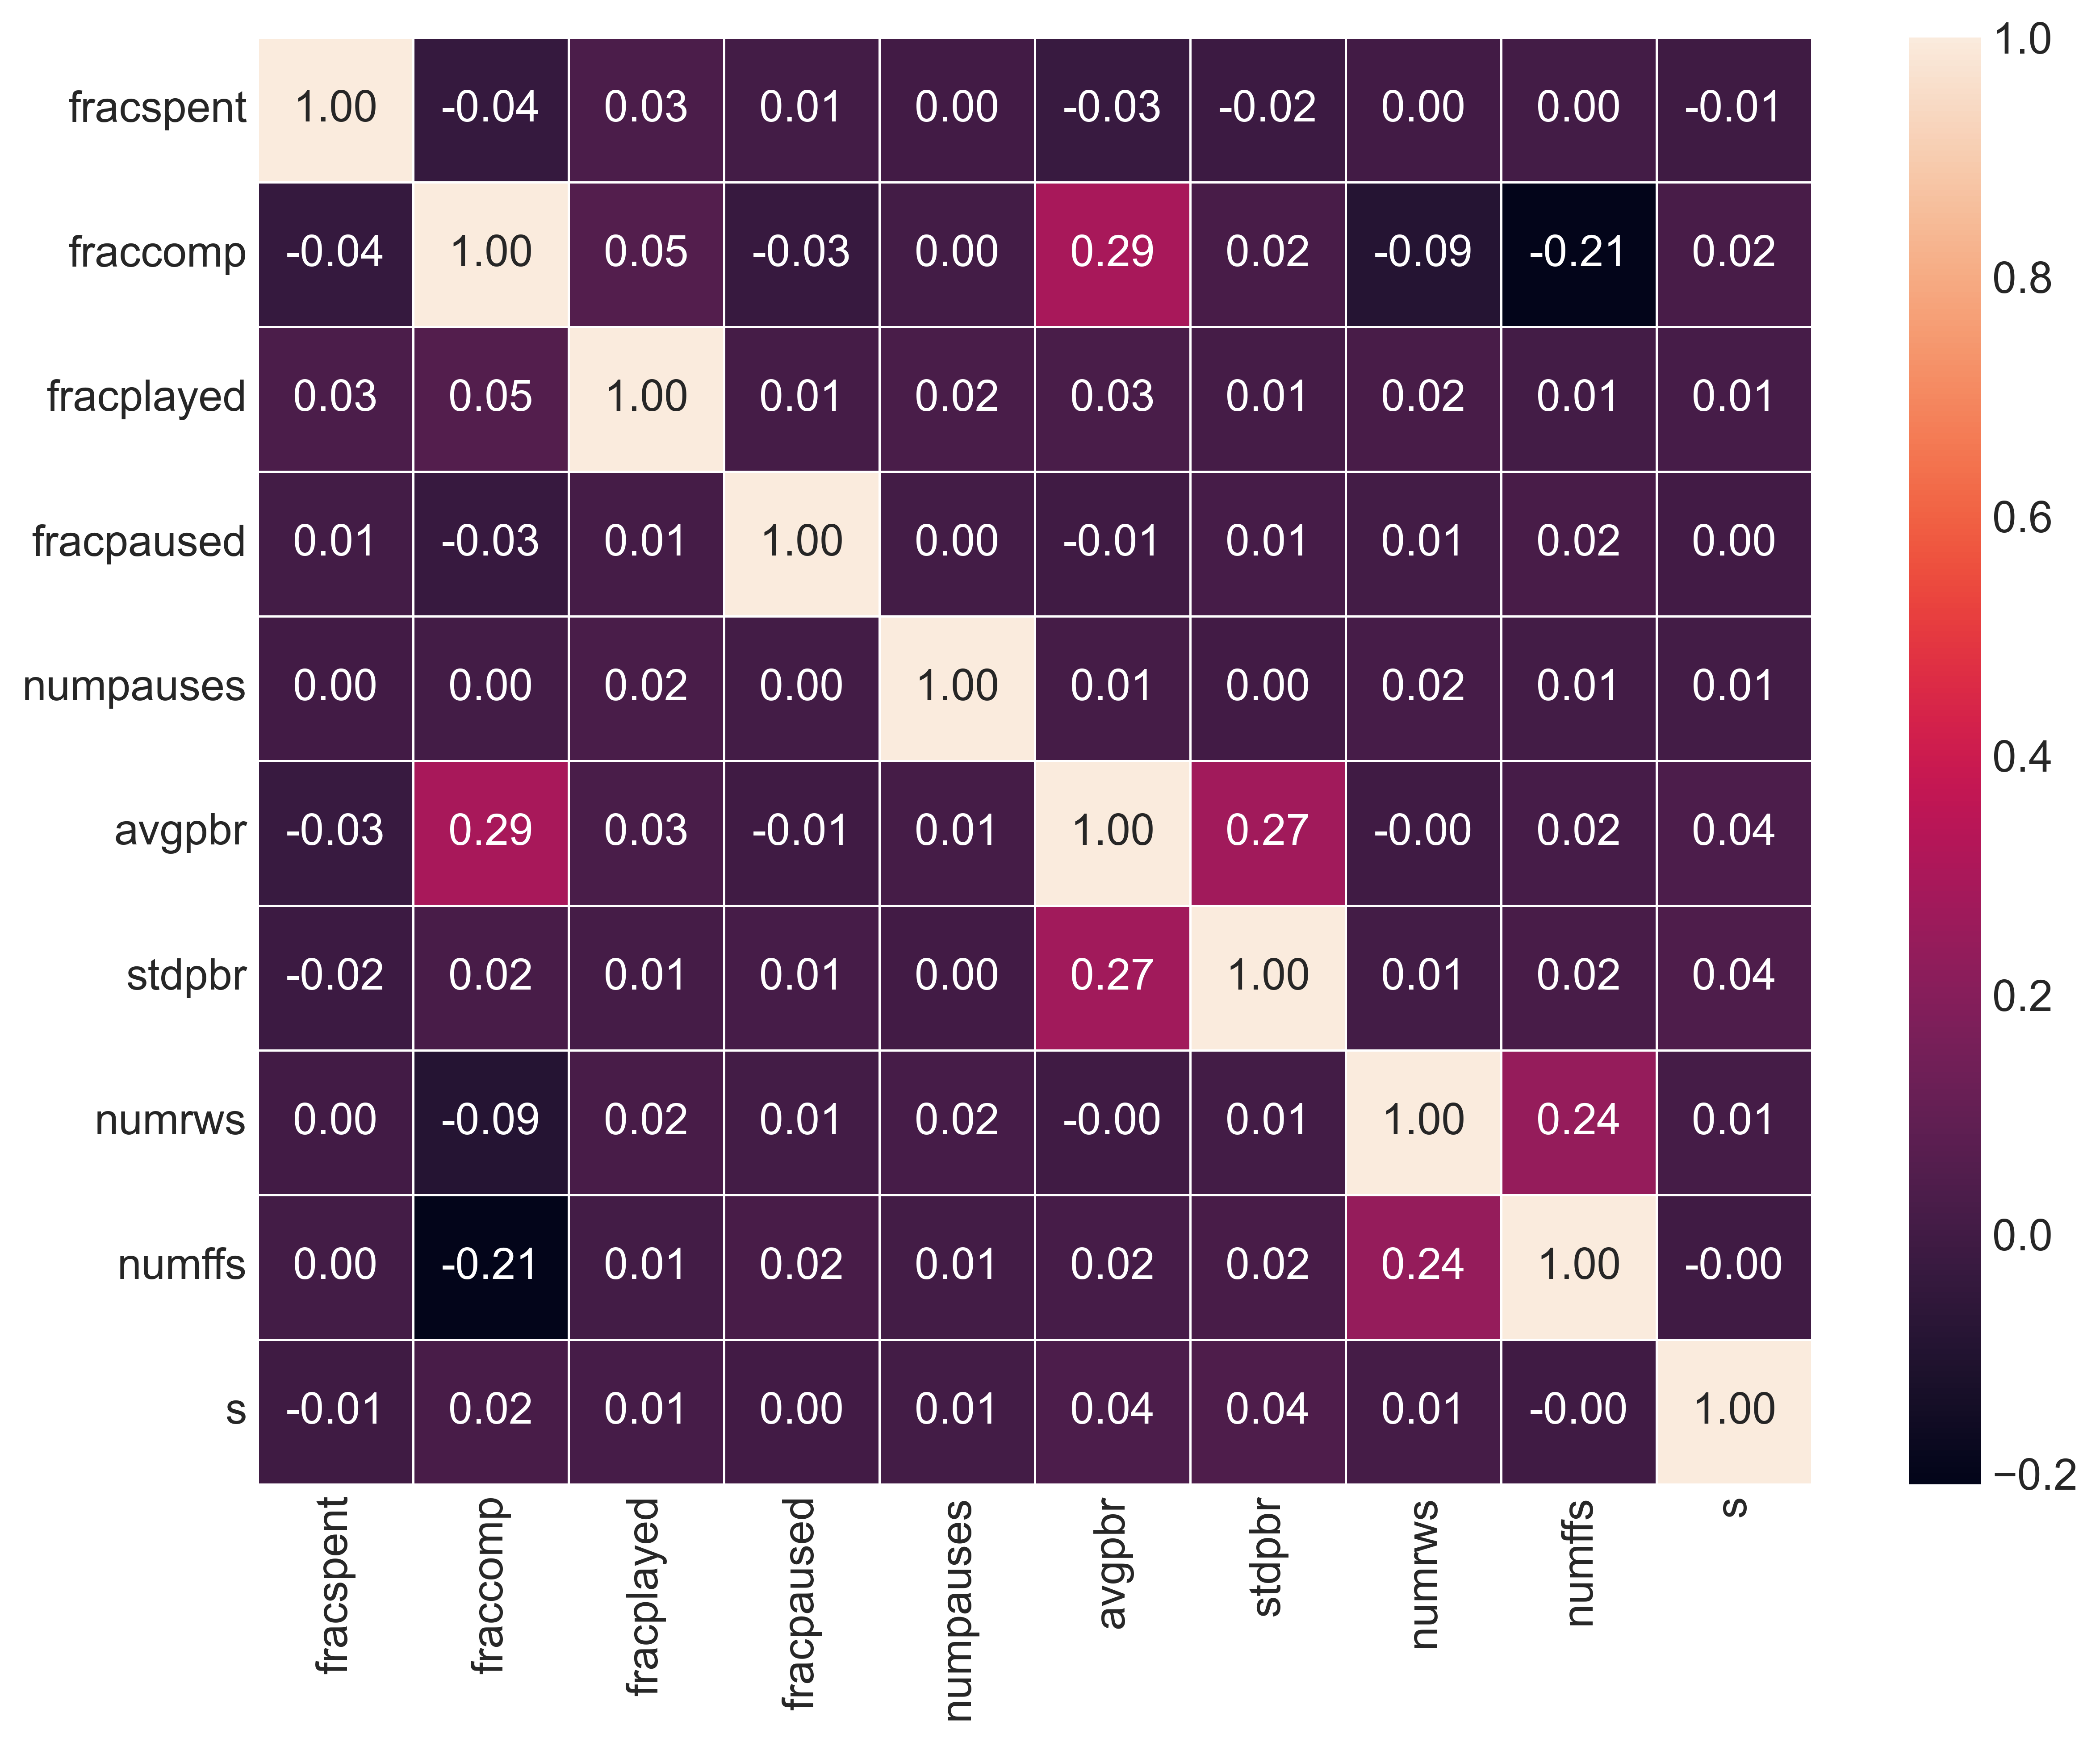

In [523]:
std_corr = student_behaviour_dataset.drop(columns=["vidid", "userid"])
corr = std_corr.corr(method="pearson")
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()


In [524]:
'''Since fraction spent on the video is represented by fracplayed, fracspent, fraccomp
are all insinuating how much time a student spends on a video we are going to work with
fraccomp: which is the fraction of the video the student plays to the duration of the 
video itself...

we also consider the number of rewinds as part of student learning behaviour, denoting
how many times the student needed to watch the video in order to understand, it also 
answers questions regarding how understandable the video was

Student success, after taking the quiz concerning the video they watched.

numffs is the number of times the student fast fowards the video when learning'''



student_video_pair = student_behaviour_dataset[["userid", "vidid","fraccomp", "numrws", "numffs", "s"]]
student_video_pair.sample(5)

,userid,vidid,fraccomp,numrws,numffs,s
26063,1891a61af06bd9bee94e03404ee002e1b99ba8a1,55,0.657485,1,0,1
29114,a97a0fb3d64debc08c5e7b7daefca16e0b8e63ea,89,0.997728,0,0,0
26562,be55afb3dd2f6813d231118e94c8f45195d919b4,59,0.696274,4,0,1
9571,a87a50c3e71d02682d79873f5ffac1d2a11aa248,6,0.995979,0,0,1
18052,3d1b887e21f2bd824400ec179dbd08feb0eaec71,16,0.727424,3,0,1


In [525]:
# success_perc = student_video_pair.groupby("userid")[['s']].\
#     agg(lambda x: sum(x)/(x.count())).\
#         sort_values(by="s", ascending=False)
# success_perc

student_groups = student_video_pair.groupby("userid").agg('mean').drop(columns="vidid")
# student_groups["s_perc"] = success_perc
vid_count = student_video_pair.groupby("userid").count()
student_groups["vidcount"] = vid_count['s']
student_groups.head(3)

,fraccomp,numrws,numffs,s,vidcount
userid,,,,,
0002a8040dd93a3b460539c4eaa0e78750da40dd,0.702957,0.733333,0.333333,0.933333,15
000d165a33bd778527872a19d05cbf054e2abb66,0.705346,12.666667,0.666667,1.000000,3
0017ef926fb44097f09150723612a5c2d5cc4af9,0.995355,0.000000,0.000000,0.750000,4


## Cluster students based on their learning pattern
Cluster 3972 students into different clusters

In [526]:
scaler = StandardScaler()
stud_scaled = scaler.fit_transform(student_groups)


cluster = KMeans(n_clusters=3, init="random", n_init=10, max_iter=300, random_state=123)

fitted_cluster = cluster.fit(stud_scaled)

print({
        "Lowest SSE value":fitted_cluster.inertia_, 
        "locations of centroids": fitted_cluster.cluster_centers_, 
        "no of iterations": fitted_cluster.n_iter_,
        "labels": fitted_cluster.labels_[:5]
    })


{'Lowest SSE value': 13879.02649476512, 'locations of centroids': array([[ 0.4362248 , -0.07177651, -0.18516763,  0.02768846, -0.17234022],
       [-1.61717778,  0.27863942,  0.71219394, -0.10998689, -0.25275531],
       [-0.05170953, -0.04225977, -0.08217955,  0.02641272,  3.62779263]]), 'no of iterations': 16, 'labels': array([0, 0, 0, 0, 0])}


In [527]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(stud_scaled)
    sse.append(kmeans.inertia_)

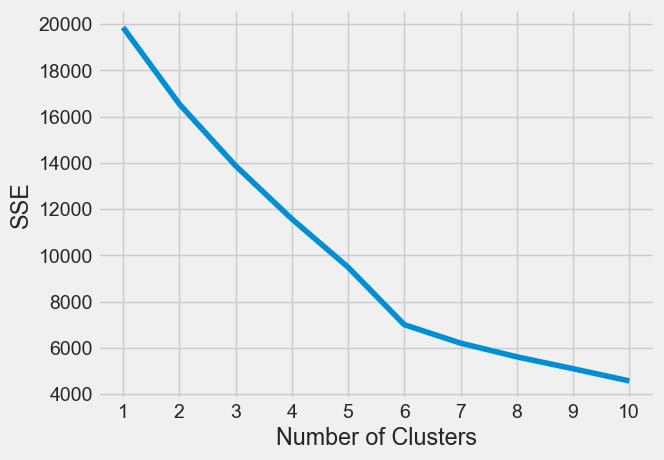

In [528]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [529]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )

kl.elbow

6

In [530]:
### Get PCA transformation
pca = PCA(2)

stud_pca = pca.fit_transform(stud_scaled)
stud_pca

array([[-0.07121969,  0.9503433 ],
       [ 0.4509312 ,  0.72018497],
       [-0.78607264,  0.18452289],
       ...,
       [-0.66857969,  2.17309273],
       [-0.85386021, -1.70123318],
       [-0.76084393,  0.63561725]])

In [531]:
label = cluster.fit_predict(stud_pca)
print(label[-4:])

[2 0 1 0]


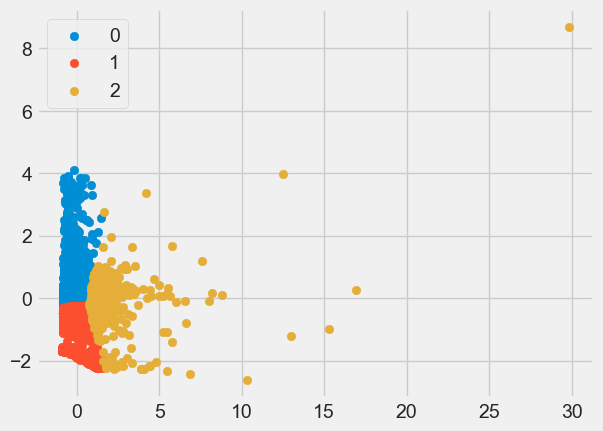

In [532]:
u_labels = np.unique(label)
u_labels

for i in u_labels:
    plt.scatter(stud_pca[label == i , 0] , stud_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

In [533]:
student_groups["classes"] = pd.Series(label, index=student_groups.index)
student_groups.head(3)

,fraccomp,numrws,numffs,s,vidcount,classes
userid,,,,,,
0002a8040dd93a3b460539c4eaa0e78750da40dd,0.702957,0.733333,0.333333,0.933333,15,0
000d165a33bd778527872a19d05cbf054e2abb66,0.705346,12.666667,0.666667,1.000000,3,0
0017ef926fb44097f09150723612a5c2d5cc4af9,0.995355,0.000000,0.000000,0.750000,4,0


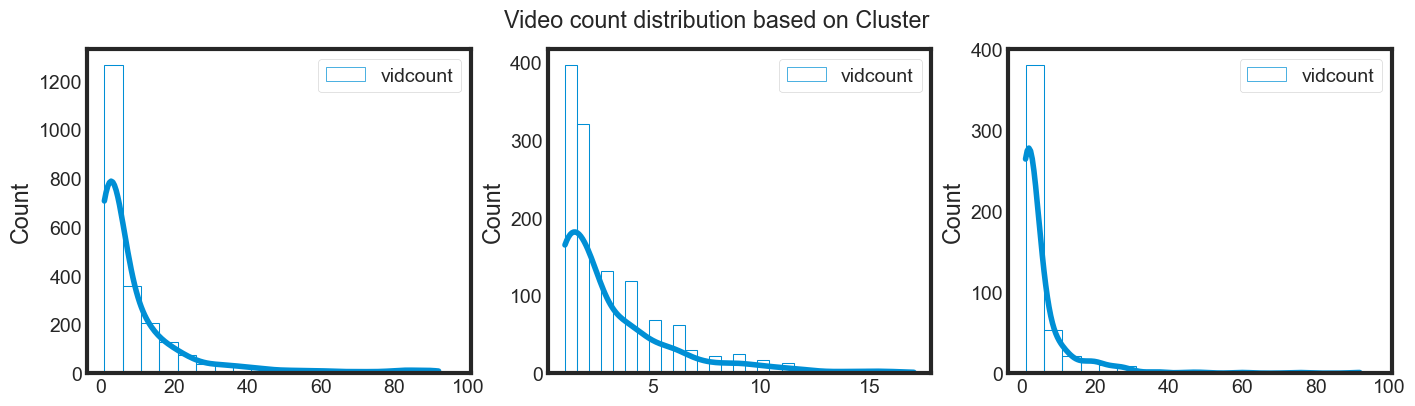

In [534]:
# ## Visualize students in each group based on the number of videos they watched and their success
# fig, axes = plt.subplots(2, 3, figsize=(10,6), dpi=100, sharex=True, sharey=True)
# colors = ['red', 'blue', 'green', 'tab:pink', 'tab:olive']

# for i, (ax, classes) in enumerate(zip(axes.flatten(), student_groups.classes.unique())):
#     x = student_groups.loc[student_groups.classes==classes, 'vidcount']
#     ax.hist(x, alpha=0.5, bins=5, density=True, stacked=True, label=str(classes), color=colors[i])
#     ax.set_title(classes)
#     print(colors[i])

# plt.suptitle('Probability Histogram of Diamond Depths', y=1.05, size=16)
# # ax.set_xlim(50, 70)
# # ax.set_ylim(0, 100)
# # plt.tight_layout()

sns.set_style("white")


x1 = student_groups.loc[student_groups.classes==0, ['vidcount']]
x2 = student_groups.loc[student_groups.classes==1, ['vidcount']]
x3 = student_groups.loc[student_groups.classes==2, ['vidcount']]
# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.histplot(x1, fill=False, edgecolor="red", binwidth=5, ax=axes[0], label='1',kde=True)
sns.histplot(x2, fill=False, color='deeppink', ax=axes[1], label='2', kde=True)
sns.histplot(x3, fill=False, color="gold", binwidth=5, ax=axes[2], label='3', kde=True)

fig.suptitle("Video count distribution based on Cluster")
fig.set_label("video count")
plt.show()
# sns.histplot(x1, color=colors[0])

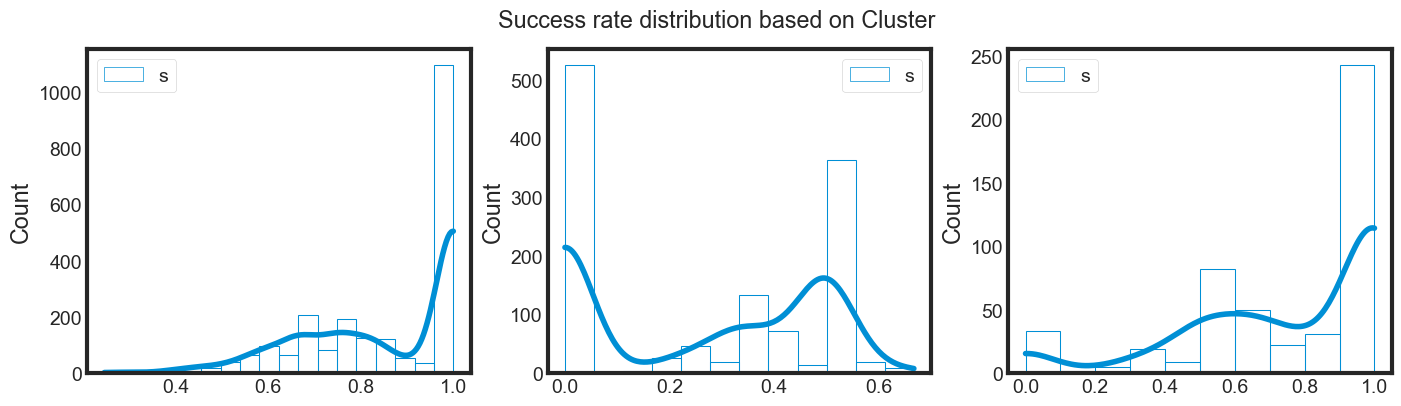

In [535]:
x1 = student_groups.loc[student_groups.classes==0, ['s']]
x2 = student_groups.loc[student_groups.classes==1, ['s']]
x3 = student_groups.loc[student_groups.classes==2, ['s']]
# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.histplot(x1, fill=False, edgecolor="red", ax=axes[0], label='1',kde=True)
sns.histplot(x2, fill=False, edgecolor='deeppink', ax=axes[1], label='2', kde=True)
sns.histplot(x3, fill=False, edgecolor="gold", ax=axes[2], label='3', kde=True)

fig.suptitle("Success rate distribution based on Cluster")
fig.set_label("video count")
plt.show()

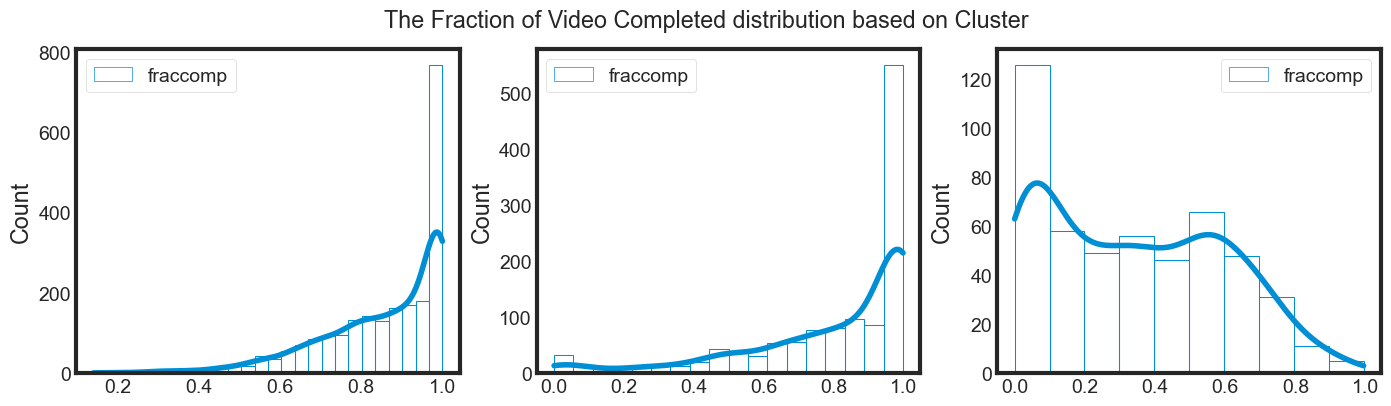

In [536]:
x1 = student_groups.loc[student_groups.classes==0, ['fraccomp']]
x2 = student_groups.loc[student_groups.classes==1, ['fraccomp']]
x3 = student_groups.loc[student_groups.classes==2, ['fraccomp']]
# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.histplot(x1, fill=False, edgecolor="red", ax=axes[0], label='1',kde=True)
sns.histplot(x2, fill=False, edgecolor='deeppink', ax=axes[1], label='2', kde=True)
sns.histplot(x3, fill=False, edgecolor="gold", ax=axes[2], label='3', kde=True)

fig.suptitle("The Fraction of Video Completed distribution based on Cluster")
fig.set_label("video count")
plt.show()

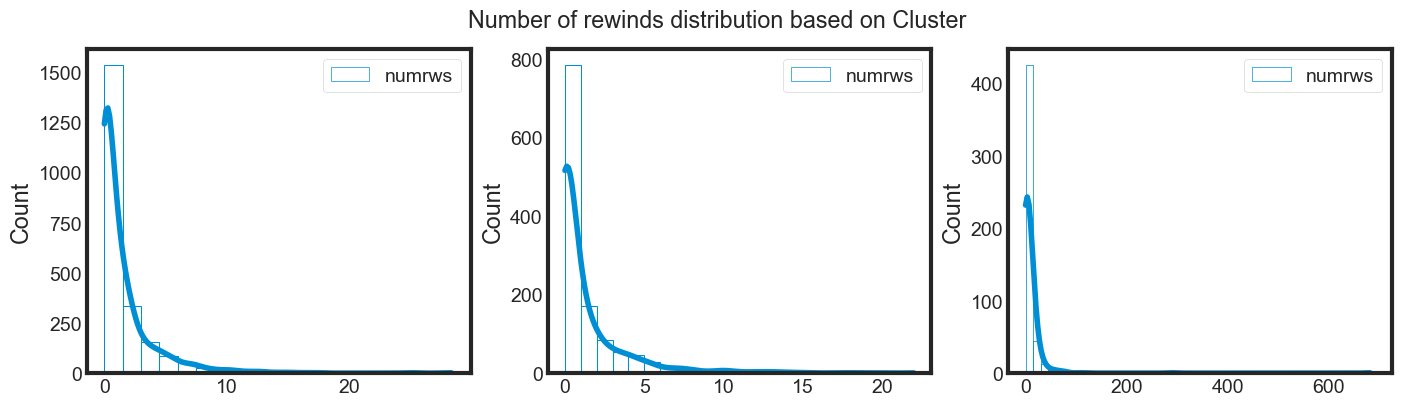

In [537]:
x1 = student_groups.loc[student_groups.classes==0, ['numrws']]
x2 = student_groups.loc[student_groups.classes==1, ['numrws']]
x3 = student_groups.loc[student_groups.classes==2, ['numrws']]
# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.histplot(x1, fill=False, binwidth=1.5, edgecolor="red", ax=axes[0], label='1',kde=True)
sns.histplot(x2, fill=False, binwidth=1, edgecolor='deeppink', ax=axes[1], label='2', kde=True)
sns.histplot(x3, fill=False, binwidth=15, edgecolor="gold", ax=axes[2], label='3', kde=True)

fig.suptitle("Number of rewinds distribution based on Cluster")
fig.set_label("video count")
plt.show()

Clustered into three groups, Very Seriou, Unserious and Average Students based on Video count and success rate after quiz

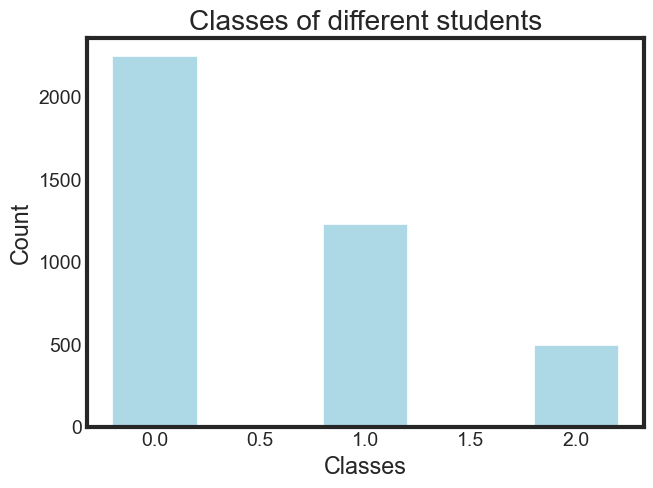

In [538]:
## Barplot of the students category

x = student_groups.groupby("classes")[['classes']].count()
x.index.name = "class"
class_group = x.reset_index().rename(columns={'classes': 'count'})

plt.bar(class_group['class'], class_group['count'], color="lightblue", width=.4)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Classes of different students")
plt.show()

From all our analysis above... We can classify our students into 3, (0)Active students who take time to watch and learn through the videos and have high success rate in respect to the number of videos they watch, we also have the potential students who take their time to watch these videos but still have low success rate, Our main focus, and we also have the ones, who don't even spend time on the videos (Inactive students) but still have high success rate. They are the somewhat intelligent ones.

In [539]:
## Calculate video engagement / ratings by student, according to the formular from chatgpt
# Define weights for each factor (you can adjust these as needed)
quiz_weight = 0.4  # Weight for quiz success
completion_weight = 0.3  # Weight for fraction of video completed
rewind_weight = 0.2  # Weight for number of times rewound
fast_forward_weight = 0.2  # Weight for number of times fast forward

# Sample data (replace this with your actual data)
quiz_success = student_video_pair["s"]  # Quiz success rate (e.g., 80%)
fraction_completed = student_video_pair["fraccomp"]  # Fraction of video completed (e.g., 70%)
rewind_count = student_video_pair["numrws"]  # Number of times video was rewound
fast_forward_count = student_video_pair["numffs"]  # Number of times video was rewound

# Calculate engagement score
engagement_score = (
    quiz_weight * quiz_success +
    completion_weight * fraction_completed +
    rewind_weight *  rewind_count + 
    fast_forward_weight * (1 / (1 + fast_forward_count)) 
)

# Display the engagement score
print(engagement_score)

student_video_pair["engagement"] = engagement_score


0        0.498670
1        0.297400
2        1.248748
3        0.482305
4        2.026299
           ...   
29299    1.099226
29300    0.899221
29301    0.677339
29302    0.899235
29303    1.084603
Length: 29160, dtype: float64


C:\Users\ZBOOK\AppData\Local\Temp\ipykernel_45952\4078476444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_video_pair["engagement"] = engagement_score


In [540]:
## Since our main focus is on improving performance, what can we say is that thing group 1
## is doing that group 2 is not doing to make them score high in quizzes?

active_students = student_groups[student_groups["classes"] == 0].reset_index()
potential_students = student_groups[student_groups["classes"] == 1].reset_index()
inactive_students = student_groups[student_groups["classes"] == 2].reset_index()

active_student_vids = student_video_pair[student_video_pair["userid"].\
    isin(active_students["userid"])].\
        reset_index().drop(columns="index")

potential_students_vids = student_video_pair[student_video_pair["userid"].\
    isin(potential_students["userid"])].\
        reset_index().drop(columns="index")
        
inactive_students_vids = student_video_pair[student_video_pair["userid"].\
    isin(inactive_students["userid"])].\
        reset_index().drop(columns="index")

In [541]:
print(active_student_vids.head(3))
print(potential_students_vids.head(3))
print(inactive_students_vids.head(3))

                                     userid  vidid  fraccomp  numrws  numffs  \
0  210f854b0afc3d476d711b2b41379954e48cfa44      0  0.858001       0       4   
1  e16cf25ff5bb827bf3b5a0c8afeed15c2223a8b5      0  0.829160       2       0   
2  721c5aba958a008c0c12576d213d3e31f938acd3      0  0.995504       0       0   

   s  engagement  
0  0    0.297400  
1  1    1.248748  
2  0    0.498651  
                                     userid  vidid  fraccomp  numrws  numffs  \
0  718eaa5dec19bcf6c7fea0870dd102dbe844fbbb      0  0.995568       0       0   
1  46dff32368088c11707106514f0450518d19b30d      0  0.857684       1       7   
2  8a861f5af4ed0668eb03bd8a77d2b7ced04f901e      0  0.754330       6       0   

   s  engagement  
0  0    0.498670  
1  0    0.482305  
2  1    2.026299  
                                     userid  vidid  fraccomp  numrws  numffs  \
0  23f1a996532c1f6364409247f5cf5f39a74ed51c      0  0.361980       0      22   
1  4b6c249e8bad484758f705bba03448d62f8c55a1   

In [542]:
video_groups = student_video_pair.drop(columns="userid").\
    groupby("vidid").\
        agg('mean').reset_index()

user_count = student_video_pair.drop(columns="userid").groupby("vidid").count()
video_groups["usercount"] = user_count['s']

video_groups.sort_values(by="s", ascending=False).head(3)

,vidid,fraccomp,numrws,numffs,s,engagement,usercount
26,26,0.793276,1.247126,1.376437,0.936782,1.021873,348.0
72,73,0.671805,1.061538,0.938462,0.915385,0.956718,147.0
71,72,0.700295,1.013605,0.809524,0.897959,0.948969,67.0


In [543]:
## Personalized Recommendation for improved performance

tmp_data = student_video_pair.copy()
tmp_data['userid'] = pd.Categorical(tmp_data['userid']).codes

tmp_pivot = tmp_data.pivot_table(index="userid", columns="vidid", values="engagement")

tmp_pivot

vidid,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
userid,,,,,,,,,,,,,,,,,,,,,
0,0.898654,1.046184,0.897818,1.501265,0.601539,0.509520,0.898811,0.898131,1.075327,0.784908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.608262,NaN,NaN,NaN,NaN,NaN,5.042661,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.498688,NaN,NaN,NaN,NaN,NaN,0.898791,0.898119,0.898828,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.872065,0.697840,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3967,0.743194,0.898449,0.897786,0.898701,0.898895,0.898752,0.898801,1.239788,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3968,0.649972,0.600303,0.600000,0.602007,1.009952,0.658130,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3969,0.898653,0.898434,0.897837,0.898676,0.498902,0.898764,0.898801,0.898139,0.898821,0.498797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [544]:
tmp_pivot_scaled = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).\
    fit_transform(tmp_pivot.values),columns=tmp_pivot.columns, index=tmp_pivot.index)

tmp_pivot_scaled.head(3)

vidid,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
userid,,,,,,,,,,,,,,,,,,,,,
0,0.006389,0.019742,0.030119,0.077666,0.001302,0.007966,0.050319,0.052149,0.045577,0.015163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.011578,NaN,NaN,NaN,NaN,NaN,0.308406,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003464,NaN,NaN,NaN,NaN,NaN,0.050318,0.052148,0.037873,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [545]:
### Train Test Split

split = int(0.8*tmp_pivot_scaled.shape[1])
tmp_train = tmp_pivot.loc[:, :split-1]
tmp_test = tmp_pivot.loc[:, split:]



train = tmp_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
test = tmp_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

train.shape, test.shape



((27698, 3), (1462, 3))

In [546]:
embeddings_size = 50
vid, usr = tmp_pivot_scaled.shape[0], tmp_pivot_scaled.shape[1]+1

usr, vid

(93, 3972)

In [547]:
## embeddings and reshape
xusers_in = Input(name="xusers_in", shape=(1,))
xvid_in = Input(name="xvid_in", shape=(1,))


embeddings_size = 50

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xvid_emb = Embedding(name="cf_xvid_emb", input_dim=vid, output_dim=embeddings_size)(xvid_in)
cf_vids = Reshape(name='cf_vids', target_shape=(embeddings_size,))(cf_xvid_emb)
## product
cf_xx = Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_vids])

nn_xusers_emb = Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xvid_emb = Embedding(name="nn_xvid_emb", input_dim=vid, output_dim=embeddings_size)(xvid_in)
nn_xvid = Reshape(name='nn_xvid', target_shape=(embeddings_size,))(nn_xvid_emb)
## concat and dense
nn_xx = Concatenate()([nn_xusers, nn_xvid])
nn_xx = Dense(name="nn_xx", units=int(embeddings_size//2), activation='relu')(nn_xx)

# Merge A & B
y_out = Concatenate()([cf_xx, nn_xx])
y_out = Dense(name="y_out", units=1, activation='linear')(y_out)
# Compile
model = Model(inputs=[xusers_in,xvid_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])


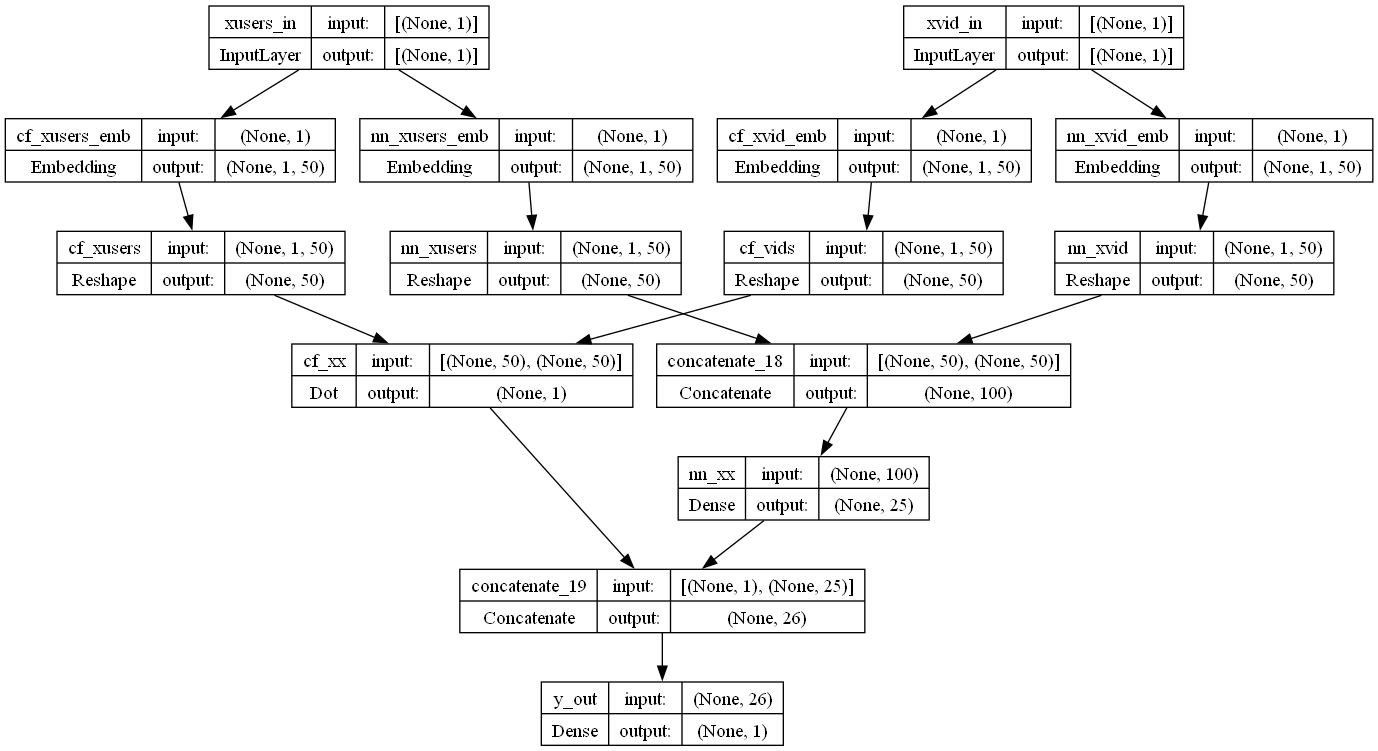

In [548]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [549]:
training = model.fit(x=[train["vidid"], train["userid"]], y=train["y"], epochs=100, batch_size=120, shuffle=True, verbose=1, validation_split=0.3)

Epoch 1/100
162/162 [==============================] - 2s 7ms/step - loss: 0.6303 - mean_absolute_percentage_error: 58.1944 - val_loss: 0.5421 - val_mean_absolute_percentage_error: 51.6591
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4706 - mean_absolute_percentage_error: 43.3764 - val_loss: 0.5434 - val_mean_absolute_percentage_error: 51.9830
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4268 - mean_absolute_percentage_error: 37.3092 - val_loss: 0.5466 - val_mean_absolute_percentage_error: 53.1931
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 0.3915 - mean_absolute_percentage_error: 32.2572 - val_loss: 0.5507 - val_mean_absolute_percentage_error: 54.8500
Epoch 5/100
162/162 [==============================] - 1s 8ms/step - loss: 0.3646 - mean_absolute_percentage_error: 28.4536 - val_loss: 0.5543 - val_mean_absolute_percentage_error: 56.2219
Epoch 6/100
162/162 [==============================] - 

In [550]:
test["yhat"] = model.predict([test["vidid"], test["userid"]])
test["yhat"] = test["yhat"]
test.head()

46/46 [==============================] - 0s 2ms/step


,userid,vidid,y,yhat
0,7,74,0.437215,1.022947
1,65,73,0.103526,0.565074
2,65,74,0.899043,0.657838
3,65,75,0.399179,0.054463
4,65,76,0.588482,0.446279


In [551]:
test['y'] = round(test['y'], 2)
test['yhat'] = round(test['yhat'], 2)
test

,userid,vidid,y,yhat
0,7,74,0.44,1.02
1,65,73,0.10,0.57
2,65,74,0.90,0.66
3,65,75,0.40,0.05
4,65,76,0.59,0.45
...,...,...,...,...
1457,3938,77,0.90,0.82
1458,3938,78,0.50,1.33
1459,3938,79,0.90,0.00
1460,3938,80,2.21,0.47


In [552]:
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [553]:
def recommend_videos(userid):
    
    # Select a user
    
    i = userid
    single_train = tmp_train.iloc[i].to_frame(name="y")
    single_test = tmp_test.iloc[i].to_frame(name="y")
    
    # add all the test products but hide the y
    
    tmp = single_test.copy()
    tmp["y"] = np.nan
    single_train = pd.concat([single_train, tmp], axis=0)
    
    single_train["userid"] = i
    single_train = single_train.reset_index()
    
    single_train["y"] = round(single_train["y"], 2)
    single_train["yhat"] = model.predict([single_train['vidid'], single_train['userid']])
    single_train['yhat'] = round(single_train['yhat'], 2)
    
    return single_train


In [554]:
def getuserprediction_metrics(data, top):
    single_train = data
    print("--- user", single_train["userid"][0], "---")
    # print(test)
    y_test = single_train.sort_values("y", ascending=False)["vidid"].values[:top]
    print("y_test:", y_test)
    predicted = single_train.sort_values("yhat", ascending=False)["vidid"].values[:top]
    print("predicted:", predicted)
    true_positive = len(list(set(y_test) & set(predicted)))
    print(
        "true positive:", 
        true_positive, 
        f"({str(round(true_positive/top*100,1))}%)"
    )
    print(
        "accuracy:", 
        f"{str(round(accuracy_score(y_test,predicted)*100,1))}%")
    print("mrr:", mean_reciprocal_rank(y_test, predicted))
    

In [561]:
user_recommendations = recommend_videos(3970)

getuserprediction_metrics(user_recommendations, 10)

3/3 [==============================] - 0s 0s/step
--- user 3970 ---
y_test: [0 1 2 3 4 5 6 7 8 9]
predicted: [72 84 27 65 68 78 51 60 31 69]
true positive: 0 (0.0%)
accuracy: 0.0%
mrr: 0.0


In [565]:
## Improving performance with recommendations
# student_groups = student_groups.reset_index()
stud_tmp = student_video_pair.reset_index().copy()
stud_tmp['userid'] = pd.Categorical(stud_tmp['userid']).codes

# print(student_groups)

rec = user_recommendations[['userid','vidid','y','yhat']]
userid = rec['userid'][0]

stud_tmp[stud_tmp['userid'] == userid]


,index,userid,vidid,fraccomp,numrws,numffs,s,engagement
1554,1560,3970,0,0.995528,0,0,0,0.498658


In [580]:
personalized_videos = user_recommendations.sort_values(by="yhat", ascending=False)["vidid"]
top_10 = personalized_videos[:10]
final_recommended_videos = video_groups[video_groups["vidid"].isin(top_10)].sort_values(by=["s"], ascending=False)
print(f"====================== Recommended Videos for student {userid} ===========================")
print(f"{np.array(final_recommended_videos['vidid'])}")
print(final_recommended_videos)

====================== Recommended Videos for user 3970 ===========================
[72 78 51 69 84 31 27 60 65 68]
    vidid  fraccomp    numrws    numffs         s  engagement  usercount
71     72  0.700295  1.013605  0.809524  0.897959    0.948969       67.0
77     78  0.721985  1.275862  0.666667  0.770115    0.954365      110.0
50     51  0.729761  2.574257  1.386139  0.663366    1.144675      121.0
68     69  0.710809  1.495238  0.485714  0.647619    0.943391      146.0
83     84  0.631396  2.172414  0.620690  0.603448    1.033316       64.0
30     31  0.818300  1.168449  0.949198  0.529412    0.859698      207.0
27     27  0.809801  1.547529  0.984791  0.520913    0.932907      263.0
59     60  0.695352  3.729730  2.747748  0.486486    1.306091      123.0
64     65  0.712477  1.927536  1.811594  0.449275    0.942535       84.0
67     68  0.792082  1.034247  0.506849  0.438356    0.797391       66.0
